In [1]:
import numpy as np
import os
from cellpose import models
from cellpose import utils as cp_utils
from cellstitch.pipeline import *
from cellstitch.evaluation import *
from cellstitch.utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Benchmark CellStitch Stitching
Generate unstitched 2D predictions:

In [2]:
cp_model_dir = './cellpose/train/models/cellpose_residual_on_style_on_concatenation_off_train_2022_08_30_13_18_51.543479'
flow_threshold = 1
model = models.Cellpose(gpu=True, model_type='cyto2')

In [3]:
filenames = get_filenames("../data/ovules/raw/")

In [ ]:
for filename in filenames: 
    img = np.load('../data/ovules/raw/%s' % filename)
    frames = list(img)
    unstitched, _, _, _ = model.eval(frames, flow_threshold=flow_threshold) 
    np.save('./results/unstitched/%s' % filename, np.array(unstitched))

Get the benchmark results for cellpose: 

In [5]:
thresholds = np.arange(0.1, 1, 0.1)
ap_threshold = 0.5

In [7]:
# cellpose benchmark
data = [] 
for filename in filenames:
    labels = np.load('../data/ovules/labels/%s' % filename) 
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    for threshold in thresholds:
        unstitched = np.load('./results/ovules/stitching/unstitched/%s' % filename) 
        cp_stitched =  np.asarray(cp_utils.stitch3D(unstitched, stitch_threshold=threshold)) # compute stitched mask
        
        num_cells = np.unique(cp_stitched).size - 1
        d_num_cells = abs(num_cells - true_num_cells) / true_num_cells 
        
        avg_vol = get_avg_vol(cp_stitched)
        d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol
        
        ap, tp, fp, fn = average_precision(labels, cp_stitched, ap_threshold)
        
        row = [
            filename, 
            threshold, 
            d_num_cells, 
            d_avg_vol, 
            ap, 
            tp, 
            fp, 
            fn
        ]
        data.append(row)

In [8]:
cp_df = pd.DataFrame(data, columns=[
    "filename", 
    "threshold", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "rn"
])

In [9]:
cp_df.to_csv("cp_stitching_benchmark.csv", index=False)

In [10]:
# cellstitch benchmark
data = [] 
for filename in filenames:
    print("Starting %s" % filename)
    labels = np.load('../data/ovules/labels/%s' % filename)
    true_num_cells = np.unique(labels).size - 1 
    true_avg_vol = get_avg_vol(labels) 
    
    ct_stitched = np.load('./results/ovules/stitching/ct_stitched/%s' % filename) 
    
    num_cells = np.unique(ct_stitched).size - 1
    d_num_cells = abs(num_cells - true_num_cells) / true_num_cells

    avg_vol = get_avg_vol(ct_stitched)
    d_avg_vol = abs(true_avg_vol - avg_vol) / true_avg_vol

    ap, tp, fp, fn = average_precision(labels, ct_stitched, ap_threshold)
    
    row = [ 
        filename, 
        d_num_cells, 
        d_avg_vol, 
        ap, 
        tp, 
        fp, 
        fn
    ]
    
    data.append(row)

Starting N_422_ds2x.npy


/home/yining/anaconda3/envs/segmentation/lib/python3.8/site-packages/cellpose/metrics.py:205: RuntimeWarning: invalid value encountered in true_divide
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)


Starting N_457_ds2x.npy
Starting N_590_final_crop_ds2.npy
Starting N_405_B_ds2x.npy
Starting N_522_final_crop_ds2.npy
Starting N_464_ds2x.npy
Starting N_534_ds2x.npy
Starting N_454_ds2x.npy
Starting N_445_ds2x.npy
Starting N_517_ds2x.npy
Starting N_509_ds2x.npy
Starting N_425_ds2x.npy
Starting N_536_ds2x.npy
Starting N_435_final_crop_ds2.npy
Starting N_487_ds2x.npy
Starting N_535_ds2x.npy
Starting N_416_ds2x.npy
Starting N_511_final_crop_ds2.npy
Starting N_512_ds2x.npy
Starting N_420_ds2x.npy
Starting N_294_final_crop_ds2.npy
Starting N_405_A_ds2x.npy
Starting N_428_ds2x.npy
Starting N_440_ds2x.npy
Starting N_449_ds2x.npy
Starting N_404_ds2x.npy
Starting N_458_ds2x.npy
Starting N_450_ds2x.npy
Starting N_441_final_crop_ds2.npy
Starting N_451_ds2x.npy
Starting N_593_final_crop_ds2.npy


In [11]:
ct_df = pd.DataFrame(data, columns=[
    "filename", 
    "d_num_cells", 
    "d_avg_vol", 
    "ap", 
    "tp", 
    "fp", 
    "rn"
])

In [12]:
ct_df.to_csv("ct_stitching_benchmark.csv", index=False)

# Analyze Results

Number of cells and average volume.

In [26]:
cp_df = pd.read_csv("cp_stitching_benchmark.csv")
ct_df = pd.read_csv("ct_stitching_benchmark.csv")

In [27]:
col_name = "d_avg_vol" # choose between d_num_cells and d_vol 

In [28]:
cp_best_df = cp_df.groupby(['filename']).min()[col_name]
cp_best_df = cp_best_df.reset_index()
cp_best_df = cp_best_df.drop(columns=['filename'])
cp_all_df = cp_df[col_name]
cp_all_df = cp_all_df.reset_index()
cp_all_df = cp_all_df.drop(columns=['index'])
ct_df = ct_df[col_name]
ct_df = ct_df.reset_index()
ct_df = ct_df.drop(columns=['index'])
cp_best_df['method'] = 'cellpose_best'
cp_all_df['method'] = 'cellpose_all'
ct_df['method'] = 'cellstitch'
df = pd.concat([cp_best_df, cp_all_df, ct_df])

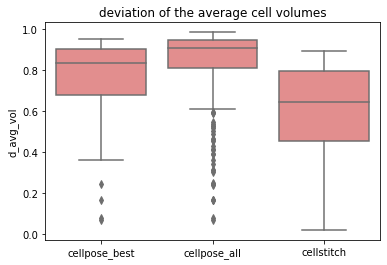

In [29]:
ax = sns.boxplot(data=df, x="method", y=col_name, color="lightcoral")
plt.title("deviation of the average cell volumes")
ax.set(xlabel=None)
plt.savefig('./figures/%s.png' % col_name)

Average precision. 

In [17]:
cp_df = pd.read_csv("cp_stitching_benchmark.csv")
ct_df = pd.read_csv("ct_stitching_benchmark.csv")

In [18]:
col_name = 'ap'

In [19]:
cp_best_df = cp_df.groupby(['filename']).max()[col_name]
cp_best_df = cp_best_df.reset_index()
cp_best_df = cp_best_df.drop(columns=['filename'])
cp_all_df = cp_df[col_name]
cp_all_df = cp_all_df.reset_index()
cp_all_df = cp_all_df.drop(columns=['index'])
ct_df = ct_df[col_name]
ct_df = ct_df.reset_index()
ct_df = ct_df.drop(columns=['index'])
cp_best_df['method'] = 'cellpose_best'
cp_all_df['method'] = 'cellpose_all'
ct_df['method'] = 'cellstitch'
df = pd.concat([cp_best_df, cp_all_df, ct_df])

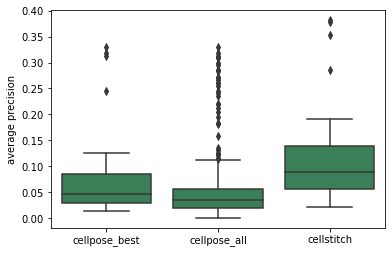

In [20]:
ax = sns.boxplot(data=df, x="method", y=col_name, color="seagreen")
ax.set(xlabel=None)
ax.set(ylabel='average precision')
plt.savefig('./figures/%s.png' % col_name)